In [43]:
import sys
sys.path.insert(1, "../src/features")
import pandas as pd
import data_cleaning

# allows all columns to be displayed
pd.set_option('display.max_columns', None)

In [44]:
OFFER_DATA_ROUGH = "../data/offer_acceptance_offers.csv"
ORDER_DATE_ROUGH = "../data/offer_acceptance_orders.csv"


OFFER_DATA_DIR = "../data/pickles/merged_clean2_outlier_removed.pkl"
ORDER_DATA_DIR = "../data/pickles/orders_clean2_outlier_removed.pkl"

offer_rough = pd.read_csv(OFFER_DATA_ROUGH)
order_rough = pd.read_csv(ORDER_DATE_ROUGH)

merged = pd.read_pickle(OFFER_DATA_DIR)
order = pd.read_pickle(ORDER_DATA_DIR).reset_index()

<ipython-input-44-95dadfb26d71>:9: DtypeWarning: Columns (9,10,11,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  order_rough = pd.read_csv(ORDER_DATE_ROUGH)


In [45]:
sys.path.insert(1, "../src/models")
import offer_number_model
import estimated_minimum_cost
import is_minimum_model

In [46]:
def merge_order_offer_on_reference(offer_df, order_df, how = "left", on = "REFERENCE_NUMBER"):
  # check df is a DataFrame
  if not isinstance(offer_df, pd.DataFrame): AssertionError("Parameter must be Pandas DataFrame")

  # check df is a DataFrame
  if not isinstance(order_df, pd.DataFrame): AssertionError("Parameter must be Pandas DataFrame")
  
  order_df = order_df.reset_index()

  
  # checks if dataframe has required columns
  req_cols = ['REFERENCE_NUMBER', 'OFFER_COUNT', "FTL_OFFER_COUNT"]

  if not set(req_cols).issubset(set(order_df.columns)): AssertionError("DataFrame order_df does not contain required columns")
  
  to_return = pd.merge(offer_df, order_df[req_cols], how = how, on = on)
  return to_return

def Kmeans_clustering(merge_df, order_df, is_test_run = False):
    from sklearn.cluster import KMeans
    import pandas as pd

    coords = pd.concat([merge_df[["ORIGIN_X", "ORIGIN_Y"]].rename({"ORIGIN_X": "X", "ORIGIN_Y": "Y"}, axis=1), merge_df[["DESTINATION_X", "DESTINATION_Y"]].rename({"DESTINATION_X": "X", "DESTINATION_Y": "Y"}, axis=1)], ignore_index=True)

    if not is_test_run:
      Kmean = KMeans(n_clusters=10)
      Kmean.fit(coords)
      coords["cluster"] = Kmean.predict(coords)
    else:
      Kmean = KMeans(n_clusters=1)
      Kmean.fit(coords)
      coords["cluster"] = Kmean.predict(coords)

    unique_cluster = coords.groupby(['X', 'Y']).first().reset_index()
    order_df["ORIGIN_CLUSTER"] = order_df[["ORIGIN_X","ORIGIN_Y"]].merge(unique_cluster, left_on = ["ORIGIN_X", "ORIGIN_Y"], right_on = ['X', 'Y'])['cluster'].values
    order_df["DESTINATION_CLUTER"] = order_df[["DESTINATION_X","DESTINATION_Y"]].merge(unique_cluster, left_on = ["DESTINATION_X", "DESTINATION_Y"], right_on = ['X', 'Y'])['cluster'].values
    orgin = list(map(str, order_df['ORIGIN_CLUSTER'].array))
    dest = list(map(str, order_df['DESTINATION_CLUTER'].array))


    order_df["ORGIN_DEST_COMB"] = [int(x+y) for x,y in zip(orgin,dest)]
    return order_df

def min_rate_df(df):
    gr = df.sort_values(["REFERENCE_NUMBER", "CREATED_ON_HQ"]).groupby("REFERENCE_NUMBER")
    df["N_OFFER"] = gr.cumcount()
    min_rate = df.groupby("REFERENCE_NUMBER").agg({"RATE_USD":"min"})
    min_rate = min_rate.reset_index().rename(columns = {"RATE_USD":"MIN_RATE"})
    df = df.merge(min_rate, on = "REFERENCE_NUMBER")
    return df

def generate_is_minimum_col(df):
    df['IS_MINIMUM'] = df['RATE_USD'] == df['MIN_RATE']
    return df

In [47]:
orders = merge_order_offer_on_reference(merged, order)

merged = Kmeans_clustering(merged, df, is_test_run = False)

merged = min_rate_df(merged)

merged = generate_is_minimum_col(merged)

In [48]:
def split_train_test(X, random_state = 44):
    from sklearn.model_selection import train_test_split

    X_train, X_test = train_test_split(X, test_size=0.3, random_state= random_state)

    return X_train, X_test

In [49]:
# split offers into train test
merged_train, merged_test = split_train_test(merged)
orders_train, orders_test = split_train_test(orders)

In [50]:
offer_number_pl, offer_number_df, offer_number_mse = offer_number_model.generate_offer_number_pipeline(merged_train, orders_train)

In [51]:
offer_number_pl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'GIVEN_HOURS',
                                                   'REMAINING_HOURS']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'REEFER_ALLOWED',
                                                   'STRAIGHT_TRUC...
                                                   'ORDER_MONTH', 'ORDER_DAY',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'ORDER_WEEK',
                                                   'DEADLINE_MONTH',
                                                   'DEADLINE_DAY',
                                                   'DEADLINE_DAY_OF_WEEK',
                                                   'DEADLINE_WEEK',
                                                   'OFFER_MONTH', 'OFFER_DAY',
                                                   'OFFER_DAY_OF_WEEK',
                                                   'OFFER_WEEK', 'OFFER_IS_FTL',
                                                   'ESTIMATED_MODE_IS_FTL',
                                                   'ORIGIN_CLUSTER',
                                                   'DESTINATION_CLUTER',
                                                   'ORGIN_DEST_COMB'])])),
                ('clf',
                 DecisionTreeClassifier(max_depth=40, min_samples_leaf=2))])

In [52]:
offer_number_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,N_OFFER,MIN_RATE,IS_MINIMUM,PREDICTED_OFFER_COUNT
522501,2007,140918,2022-10-16 16:24:08,8385.000000,0,0,2022-10-14 15:34:37,2022-10-17 16:00:00,923,350,1977.0,48.0,1,0,0,1,0,0.0,0,5585.2227,1,72.0,23.0,-1.294139e+07,4.177000e+06,-9.649898e+06,3.933844e+06,10,14,6,41,10,17,6,42,10,16,6,41,1,1,6,6,0,0,0,3,5547.000000,False,6
475961,630,128600,2022-08-26 08:30:26,1892.000000,0,0,2022-08-25 08:39:41,2022-08-26 15:00:00,302,757,689.0,22.0,1,0,0,1,1,0.0,0,1258.1628,1,30.0,6.0,-9.411655e+06,3.904063e+06,-1.061699e+07,3.774301e+06,8,25,4,34,8,26,4,34,8,26,4,34,0,0,10,0,1,4,14,7,1309.846154,False,10
80791,634,22491,2022-10-10 09:44:05,1419.000000,1,1,2022-10-07 09:45:45,2022-10-10 12:30:00,302,752,823.0,13.0,1,0,0,1,0,0.0,0,1091.0433,0,74.0,2.0,-9.411655e+06,3.904063e+06,-1.077645e+07,3.844994e+06,10,7,0,40,10,10,0,41,10,10,0,41,1,0,12,12,4,4,44,10,1290.000000,False,12
4868,2576,1251,2022-09-19 07:13:52,3418.500000,1,0,2022-09-09 09:01:56,2022-09-19 15:00:00,945,841,746.0,20.0,1,0,0,0,0,0.0,1,2385.3777,1,245.0,7.0,-1.358223e+07,4.559742e+06,-1.244634e+07,4.940963e+06,9,9,0,36,9,19,0,38,9,19,0,38,1,0,12,12,4,6,46,10,2838.000000,False,12
510159,7110,137786,2021-07-16 13:21:19,1161.000000,1,1,2021-07-15 15:53:39,2021-07-19 13:00:00,307,760,841.0,18.0,1,0,0,0,1,0.0,0,1200.2031,1,93.0,71.0,-9.474274e+06,4.100100e+06,-1.085803e+07,3.819097e+06,7,15,4,28,7,19,4,29,7,16,4,28,0,0,4,0,3,4,34,3,1161.000000,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641120,2723,173386,2021-10-05 11:46:22,1161.000000,0,0,2021-10-04 10:40:14,2021-10-13 13:00:00,952,924,397.0,7.0,1,0,0,1,0,0.0,1,623.1861,1,218.0,193.0,-1.345291e+07,4.571547e+06,-1.305804e+07,4.035667e+06,10,4,1,40,10,13,1,41,10,5,1,40,1,0,3,1,0,1,1,0,505.680000,False,3
49723,5556,13984,2020-10-20 10:15:22,915.202703,0,1,2020-10-20 08:36:26,2020-10-22 13:00:00,331,207,1073.0,15.0,1,0,0,1,1,0.0,1,1128.7500,1,52.0,50.0,-8.962210e+06,2.953391e+06,-8.548074e+06,4.678305e+06,10,20,1,43,10,22,1,43,10,20,1,43,0,0,1,0,8,5,85,0,915.202703,True,1
156845,22657,42976,2022-07-20 14:49:52,2009.684211,1,1,2022-07-20 11:15:16,2022-07-22 16:00:00,930,782,1411.0,16.0,1,0,0,0,0,0.0,0,2664.4176,1,52.0,49.0,-1.325745e+07,4.056048e+06,-1.096764e+07,3.413965e+06,7,20,2,29,7,22,2,29,7,20,2,29,0,0,13,0,1,4,14,12,2009.684211,True,13
256753,16792,69652,2022-08-24 08:43:13,873837.474783,0,0,2022-08-18 06:00:53,2022-08-24 14:00:00,770,761,266.0,8.0,1,0,0,0,0,0.0,1,586.7178,1,151.0,5.0,-1.062056e+07,3.455990e+06,-1.084046e+07,3.841212e+06,8,18,2,33,8,24,2,34,8,24,2,34,0,0,13,1,1,4,14,6,342.354783,False,13


In [53]:
offer_number_mse

In [54]:
estimated_minimum_model, estimated_minimum_df, estimated_minimum_mse = estimated_minimum_cost.generate_estimated_minimum_cost_pipeline(offer_number_df)

In [55]:
estimated_minimum_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'FTL_OFFER_COUNT',
                                                   'PREDICTED_OFFER_COUNT',
                                                   'GIVEN_HOURS']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'LOAD_T...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=10, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [56]:
estimated_minimum_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,N_OFFER,MIN_RATE,IS_MINIMUM,PREDICTED_OFFER_COUNT,PREDICTED_MIN_RATE
522501,2007,140918,2022-10-16 16:24:08,8385.000000,0,0,2022-10-14 15:34:37,2022-10-17 16:00:00,923,350,1977.0,48.0,1,0,0,1,0,0.0,0,5585.2227,1,72.0,23.0,-1.294139e+07,4.177000e+06,-9.649898e+06,3.933844e+06,10,14,6,41,10,17,6,42,10,16,6,41,1,1,6,6,0,0,0,3,5547.000000,False,6,5946.822754
475961,630,128600,2022-08-26 08:30:26,1892.000000,0,0,2022-08-25 08:39:41,2022-08-26 15:00:00,302,757,689.0,22.0,1,0,0,1,1,0.0,0,1258.1628,1,30.0,6.0,-9.411655e+06,3.904063e+06,-1.061699e+07,3.774301e+06,8,25,4,34,8,26,4,34,8,26,4,34,0,0,10,0,1,4,14,7,1309.846154,False,10,1376.951416
80791,634,22491,2022-10-10 09:44:05,1419.000000,1,1,2022-10-07 09:45:45,2022-10-10 12:30:00,302,752,823.0,13.0,1,0,0,1,0,0.0,0,1091.0433,0,74.0,2.0,-9.411655e+06,3.904063e+06,-1.077645e+07,3.844994e+06,10,7,0,40,10,10,0,41,10,10,0,41,1,0,12,12,4,4,44,10,1290.000000,False,12,1239.875244
4868,2576,1251,2022-09-19 07:13:52,3418.500000,1,0,2022-09-09 09:01:56,2022-09-19 15:00:00,945,841,746.0,20.0,1,0,0,0,0,0.0,1,2385.3777,1,245.0,7.0,-1.358223e+07,4.559742e+06,-1.244634e+07,4.940963e+06,9,9,0,36,9,19,0,38,9,19,0,38,1,0,12,12,4,6,46,10,2838.000000,False,12,2822.861816
510159,7110,137786,2021-07-16 13:21:19,1161.000000,1,1,2021-07-15 15:53:39,2021-07-19 13:00:00,307,760,841.0,18.0,1,0,0,0,1,0.0,0,1200.2031,1,93.0,71.0,-9.474274e+06,4.100100e+06,-1.085803e+07,3.819097e+06,7,15,4,28,7,19,4,29,7,16,4,28,0,0,4,0,3,4,34,3,1161.000000,True,4,1115.330933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641120,2723,173386,2021-10-05 11:46:22,1161.000000,0,0,2021-10-04 10:40:14,2021-10-13 13:00:00,952,924,397.0,7.0,1,0,0,1,0,0.0,1,623.1861,1,218.0,193.0,-1.345291e+07,4.571547e+06,-1.305804e+07,4.035667e+06,10,4,1,40,10,13,1,41,10,5,1,40,1,0,3,1,0,1,1,0,505.680000,False,3,579.820374
49723,5556,13984,2020-10-20 10:15:22,915.202703,0,1,2020-10-20 08:36:26,2020-10-22 13:00:00,331,207,1073.0,15.0,1,0,0,1,1,0.0,1,1128.7500,1,52.0,50.0,-8.962210e+06,2.953391e+06,-8.548074e+06,4.678305e+06,10,20,1,43,10,22,1,43,10,20,1,43,0,0,1,0,8,5,85,0,915.202703,True,1,913.122131
156845,22657,42976,2022-07-20 14:49:52,2009.684211,1,1,2022-07-20 11:15:16,2022-07-22 16:00:00,930,782,1411.0,16.0,1,0,0,0,0,0.0,0,2664.4176,1,52.0,49.0,-1.325745e+07,4.056048e+06,-1.096764e+07,3.413965e+06,7,20,2,29,7,22,2,29,7,20,2,29,0,0,13,0,1,4,14,12,2009.684211,True,13,1827.072388
256753,16792,69652,2022-08-24 08:43:13,873837.474783,0,0,2022-08-18 06:00:53,2022-08-24 14:00:00,770,761,266.0,8.0,1,0,0,0,0,0.0,1,586.7178,1,151.0,5.0,-1.062056e+07,3.455990e+06,-1.084046e+07,3.841212e+06,8,18,2,33,8,24,2,34,8,24,2,34,0,0,13,1,1,4,14,6,342.354783,False,13,367.717712


In [59]:
estimated_minimum_mse

In [60]:
is_minimum_pl, is_minimum_df, accuracy = is_minimum_model.generate_proba_minimum_pipeline(estimated_minimum_df)

In [61]:
is_minimum_pl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'GIVEN_HOURS',
                                                   'REMAINING_HOURS',
                                                   'PREDICTED_MIN_RATE']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'REEFER_AL...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=10, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [62]:
is_minimum_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,N_OFFER,MIN_RATE,IS_MINIMUM,PREDICTED_OFFER_COUNT,PREDICTED_MIN_RATE,PREDICTED_IS_MIN
522501,2007,140918,2022-10-16 16:24:08,8385.000000,0,0,2022-10-14 15:34:37,2022-10-17 16:00:00,923,350,1977.0,48.0,1,0,0,1,0,0.0,0,5585.2227,1,72.0,23.0,-1.294139e+07,4.177000e+06,-9.649898e+06,3.933844e+06,10,14,6,41,10,17,6,42,10,16,6,41,1,1,6,6,0,0,0,3,5547.000000,False,6,5946.822754,0
475961,630,128600,2022-08-26 08:30:26,1892.000000,0,0,2022-08-25 08:39:41,2022-08-26 15:00:00,302,757,689.0,22.0,1,0,0,1,1,0.0,0,1258.1628,1,30.0,6.0,-9.411655e+06,3.904063e+06,-1.061699e+07,3.774301e+06,8,25,4,34,8,26,4,34,8,26,4,34,0,0,10,0,1,4,14,7,1309.846154,False,10,1376.951416,0
80791,634,22491,2022-10-10 09:44:05,1419.000000,1,1,2022-10-07 09:45:45,2022-10-10 12:30:00,302,752,823.0,13.0,1,0,0,1,0,0.0,0,1091.0433,0,74.0,2.0,-9.411655e+06,3.904063e+06,-1.077645e+07,3.844994e+06,10,7,0,40,10,10,0,41,10,10,0,41,1,0,12,12,4,4,44,10,1290.000000,False,12,1239.875244,0
4868,2576,1251,2022-09-19 07:13:52,3418.500000,1,0,2022-09-09 09:01:56,2022-09-19 15:00:00,945,841,746.0,20.0,1,0,0,0,0,0.0,1,2385.3777,1,245.0,7.0,-1.358223e+07,4.559742e+06,-1.244634e+07,4.940963e+06,9,9,0,36,9,19,0,38,9,19,0,38,1,0,12,12,4,6,46,10,2838.000000,False,12,2822.861816,0
510159,7110,137786,2021-07-16 13:21:19,1161.000000,1,1,2021-07-15 15:53:39,2021-07-19 13:00:00,307,760,841.0,18.0,1,0,0,0,1,0.0,0,1200.2031,1,93.0,71.0,-9.474274e+06,4.100100e+06,-1.085803e+07,3.819097e+06,7,15,4,28,7,19,4,29,7,16,4,28,0,0,4,0,3,4,34,3,1161.000000,True,4,1115.330933,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641120,2723,173386,2021-10-05 11:46:22,1161.000000,0,0,2021-10-04 10:40:14,2021-10-13 13:00:00,952,924,397.0,7.0,1,0,0,1,0,0.0,1,623.1861,1,218.0,193.0,-1.345291e+07,4.571547e+06,-1.305804e+07,4.035667e+06,10,4,1,40,10,13,1,41,10,5,1,40,1,0,3,1,0,1,1,0,505.680000,False,3,579.820374,0
49723,5556,13984,2020-10-20 10:15:22,915.202703,0,1,2020-10-20 08:36:26,2020-10-22 13:00:00,331,207,1073.0,15.0,1,0,0,1,1,0.0,1,1128.7500,1,52.0,50.0,-8.962210e+06,2.953391e+06,-8.548074e+06,4.678305e+06,10,20,1,43,10,22,1,43,10,20,1,43,0,0,1,0,8,5,85,0,915.202703,True,1,913.122131,1
156845,22657,42976,2022-07-20 14:49:52,2009.684211,1,1,2022-07-20 11:15:16,2022-07-22 16:00:00,930,782,1411.0,16.0,1,0,0,0,0,0.0,0,2664.4176,1,52.0,49.0,-1.325745e+07,4.056048e+06,-1.096764e+07,3.413965e+06,7,20,2,29,7,22,2,29,7,20,2,29,0,0,13,0,1,4,14,12,2009.684211,True,13,1827.072388,1
256753,16792,69652,2022-08-24 08:43:13,873837.474783,0,0,2022-08-18 06:00:53,2022-08-24 14:00:00,770,761,266.0,8.0,1,0,0,0,0,0.0,1,586.7178,1,151.0,5.0,-1.062056e+07,3.455990e+06,-1.084046e+07,3.841212e+06,8,18,2,33,8,24,2,34,8,24,2,34,0,0,13,1,1,4,14,6,342.354783,False,13,367.717712,0


In [64]:
accuracy

In [65]:
merged_test["PREDICTED_OFFER_COUNT"] = offer_number_pl.predict(merged_test)
merged_test["PREDICTED_MIN_RATE"] = estimated_minimum_model.predict(merged_test)
merged_test["PREDICTED_IS_MIN"] = is_minimum_pl.predict(merged_test)

In [66]:
is_min_true = merged_test[merged_test['IS_MINIMUM'] == True]
is_min_true

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,N_OFFER,MIN_RATE,IS_MINIMUM,PREDICTED_OFFER_COUNT,PREDICTED_MIN_RATE,PREDICTED_IS_MIN
243690,1232,66169,2020-12-01 15:16:09,1677.000000,0,0,2020-12-01 12:26:09,2020-12-02 12:30:00,750,802,773.0,26.0,1,0,0,1,1,0.0,0,2361.6030,1,24.0,21.0,-1.076722e+07,3.902611e+06,-1.168323e+07,4.804984e+06,12,1,1,49,12,2,1,49,12,1,1,49,1,0,1,1,0,6,6,0,1677.000000,True,1,1774.699097,1
154303,25751,42356,2022-10-05 09:34:21,516.000000,1,0,2022-10-05 09:23:31,2022-10-06 08:00:00,275,286,161.0,24.0,1,0,0,1,0,0.0,0,719.2137,1,22.0,22.0,-8.743510e+06,4.266923e+06,-9.056021e+06,4.283788e+06,10,5,2,40,10,6,2,40,10,5,2,40,1,0,11,11,1,0,10,8,516.000000,True,11,535.360107,1
221097,2015,60122,2022-06-02 06:35:28,2064.000000,1,0,2022-06-01 12:53:44,2022-06-03 13:30:00,832,902,898.0,53.0,1,1,0,1,1,0.0,0,2038.8192,1,48.0,30.0,-1.257326e+07,5.337352e+06,-1.319381e+07,4.003687e+06,6,1,3,22,6,3,3,22,6,2,3,22,1,1,7,7,4,1,41,3,2064.000000,True,4,1692.643433,0
346736,11299,93871,2022-09-12 12:05:02,903.000000,1,1,2022-09-12 08:00:30,2022-09-13 12:00:00,917,945,389.0,12.0,1,0,0,1,0,0.0,1,907.3989,1,27.0,23.0,-1.310839e+07,4.017864e+06,-1.358223e+07,4.559742e+06,9,12,0,37,9,13,0,37,9,12,0,37,1,0,5,5,1,8,18,4,903.000000,True,5,832.967651,1
42271,11229,11932,2021-05-27 13:21:30,982.676471,1,1,2021-05-27 07:19:47,2021-05-28 15:30:00,982,917,1187.0,37.0,1,0,0,1,1,0.0,1,2006.1951,1,32.0,26.0,-1.356330e+07,6.128866e+06,-1.310839e+07,4.017864e+06,5,27,3,21,5,28,3,21,5,27,3,21,0,0,3,1,8,1,81,1,982.676471,True,3,1036.232300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213813,248,58133,2020-12-14 10:46:42,1161.000000,0,1,2020-12-07 05:53:10,2020-12-15 14:00:00,770,462,1019.0,16.0,1,0,0,1,1,0.0,1,1492.0785,1,200.0,27.0,-1.062056e+07,3.455990e+06,-9.589051e+06,4.807284e+06,12,7,0,50,12,15,0,51,12,14,0,51,1,0,1,1,1,9,19,0,1161.000000,True,3,1006.732422,0
264361,5790,71698,2022-08-31 06:24:11,154.800000,1,0,2022-08-31 03:45:53,2022-09-01 16:00:00,928,890,227.0,4.0,1,0,0,1,1,0.0,0,370.8105,1,36.0,33.0,-1.310308e+07,3.983839e+06,-1.289111e+07,4.491655e+06,8,31,2,35,9,1,2,35,8,31,2,35,0,0,1,0,1,1,11,0,154.800000,True,6,169.821457,1
308586,1572,83421,2021-07-12 12:47:23,3870.000000,0,0,2021-07-12 12:43:12,2021-07-14 10:00:00,770,481,1295.0,53.0,1,1,0,0,0,0.0,0,4981.5801,1,45.0,45.0,-1.062056e+07,3.455990e+06,-9.309512e+06,5.162989e+06,7,12,0,28,7,14,0,28,7,12,0,28,1,1,3,3,1,9,19,0,3870.000000,True,3,3743.417969,1
682342,7020,184816,2021-12-15 08:37:18,5805.000000,0,0,2021-12-15 07:23:27,2021-12-17 15:00:00,834,089,2234.0,19.0,1,0,0,1,1,0.0,1,9240.6957,1,55.0,54.0,-1.253314e+07,5.485173e+06,-8.289764e+06,4.905190e+06,12,15,2,50,12,17,2,50,12,15,2,50,1,0,5,5,3,5,35,0,5805.000000,True,5,5663.195801,1


In [67]:
Flock_count = is_min_true[is_min_true['LOAD_DELIVERED_FROM_OFFER'] == 1].shape[0]
Our_model_count = is_min_true[is_min_true['PREDICTED_IS_MIN'] == 1].shape[0]

In [72]:
Our_model_count / is_min_true.shape[0]

0.5553936083707943

In [74]:
Flock_count / is_min_true.shape[0]

0.516055784838675

In [98]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(merged_test["IS_MINIMUM"], merged_test["PREDICTED_IS_MIN"])
c_matrix

array([[126840,  14174],
       [ 28979,  36200]], dtype=int64)

In [99]:
tp = c_matrix[0][0]
fp = c_matrix[0][1]
fn = c_matrix[1][0]
tn = c_matrix[1][1]

In [101]:
accuracy = (tp + tn) / (tp + fp + fn + tp)
sensitivity = (tp) / (tp + fn)
specificity = (tn) / (tn + fp)

In [102]:
accuracy

0.5492650749748175

In [103]:
sensitivity

0.8140213966204378

In [104]:
specificity

0.7186246873387064

In [109]:
metrics = {"Sensitivity":[sensitivity], "Specificity":[specificity]}
metrics

{'Sensitivity': [0.8140213966204378], 'Specificity': [0.7186246873387064]}

<AxesSubplot: >

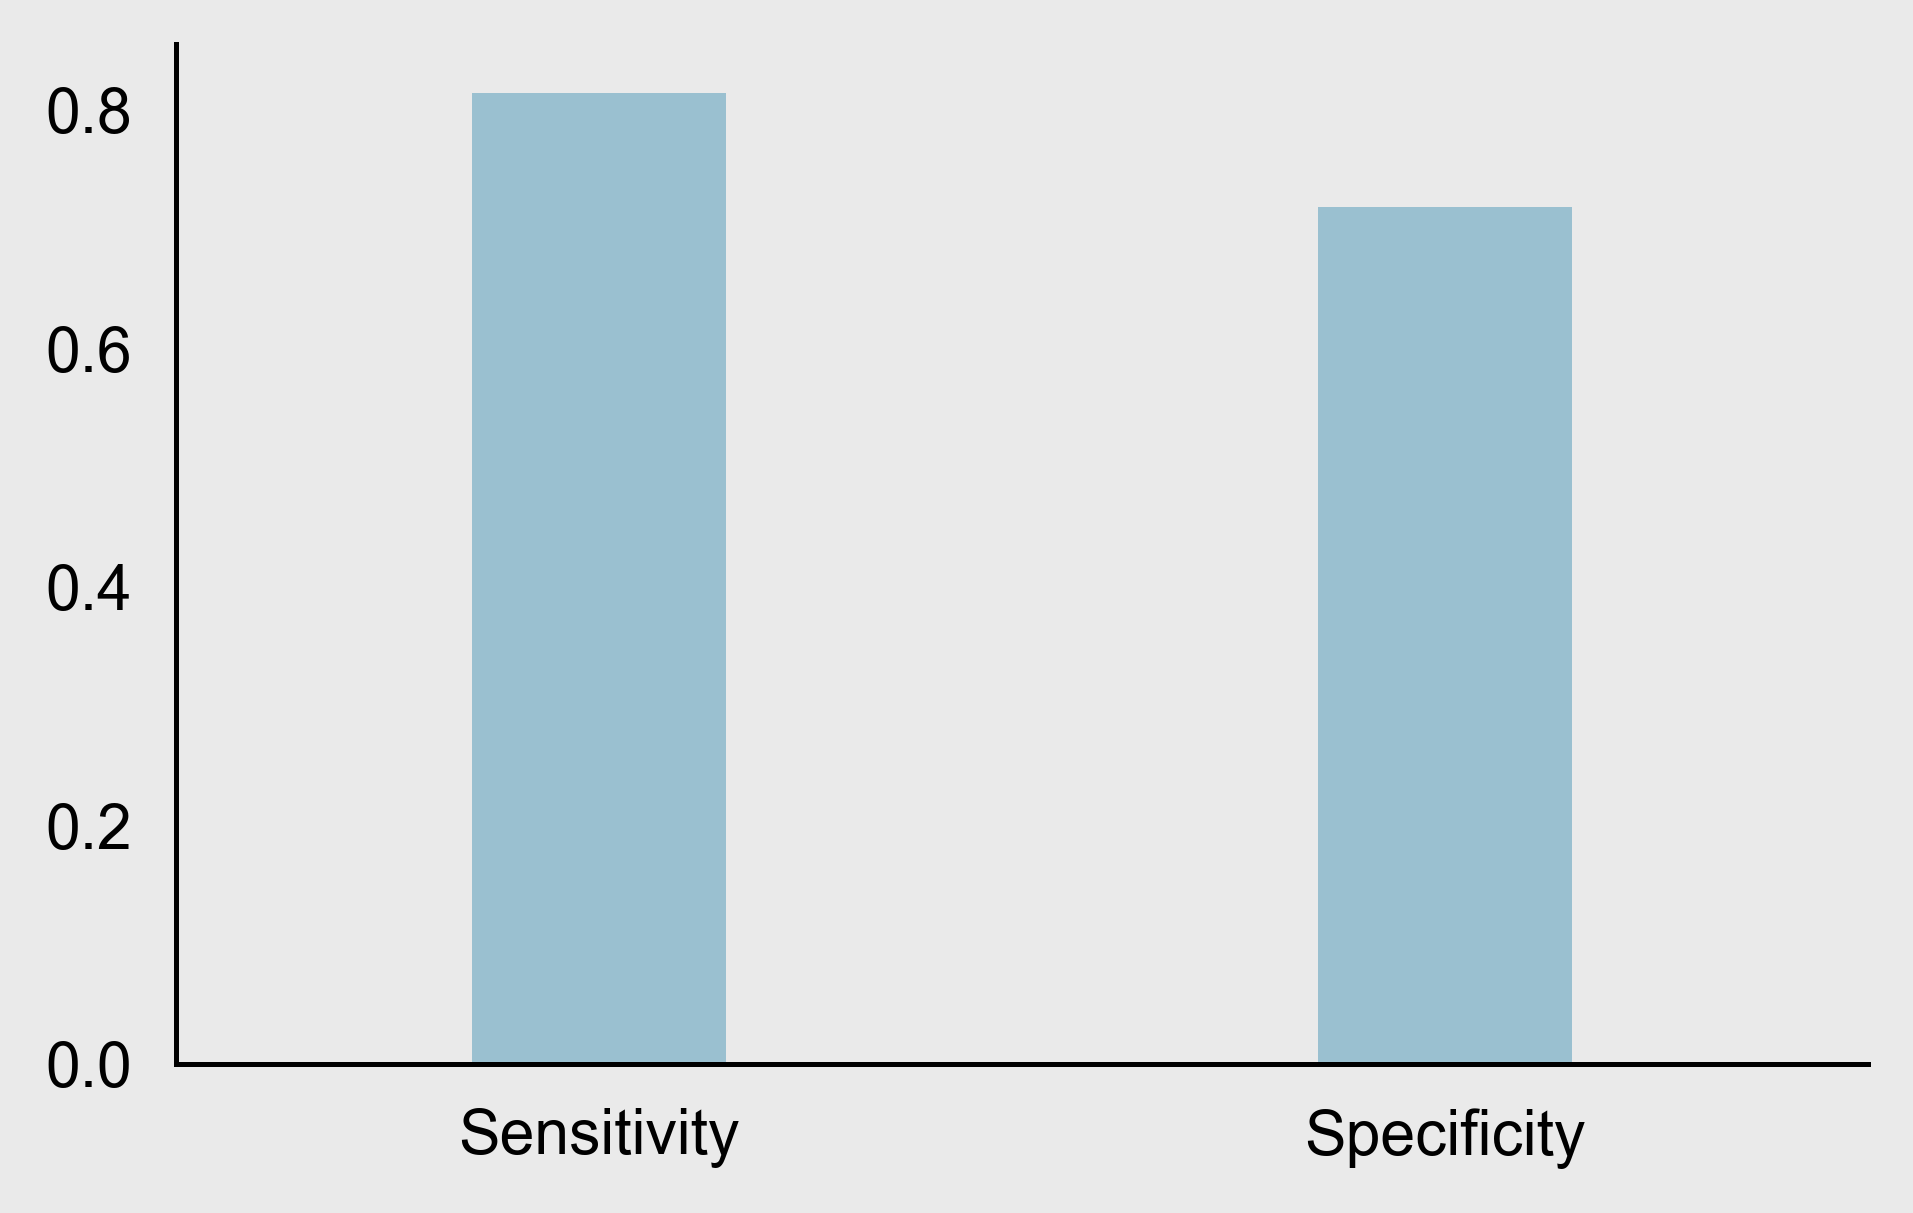

In [114]:
import matplotlib as plt
import seaborn as sns

GRAY = "#EAEAEA"
GREEN = "#44741a"
BLUE = "#91C4D9"
YELLOW = "#dfc474"
RED = "#ce344f"

rc = {'axes.facecolor':GRAY,
      'figure.facecolor':GRAY,
      'axes.grid' : False,
      'grid.color': '.9',
      'font.family':'Arial',
      'font.size' : 10,
      "figure.figsize": "4.854, 3",
      "figure.dpi": 450,
      "savefig.dpi": 450,
      "axes.spines.right": False,
      "axes.spines.left": True,
      "axes.spines.bottom": True,
      "axes.spines.top": False,
      "xtick.bottom": False,
      "ytick.left": False,
      "axes.titlepad": 20,
      # "savefig.directory": os.chdir(os.path.dirname("../../plots/eda"))
      }

plt.rcParams.update(rc)

sns.barplot(data = pd.DataFrame(metrics), palette = [BLUE,BLUE], width = 0.3)

#### Function

In [3]:
def merge_order_offer_on_reference(offer_df, order_df, how = "left", on = "REFERENCE_NUMBER"):
  # check df is a DataFrame
  if not isinstance(offer_df, pd.DataFrame): AssertionError("Parameter must be Pandas DataFrame")

  # check df is a DataFrame
  if not isinstance(order_df, pd.DataFrame): AssertionError("Parameter must be Pandas DataFrame")
  
  # checks if dataframe has required columns
  req_cols = ['REFERENCE_NUMBER', 'OFFER_COUNT', "FTL_OFFER_COUNT"]

  if not set(req_cols).issubset(set(order_df.columns)): AssertionError("DataFrame order_df does not contain required columns")
  
  return pd.merge(offer_df, order_df[req_cols], how = how, on = on)

In [4]:
merge_order = merge_order_offer_on_reference(merged, order)

#### Function

In [5]:
def Kmeans_clustering(merge_df, flatten_df):
  from sklearn.cluster import KMeans
  import pandas as pd
  
  coords = pd.concat([merge_df[["ORIGIN_X", "ORIGIN_Y"]].rename({"ORIGIN_X": "X", "ORIGIN_Y": "Y"}, axis=1), merge_df[["DESTINATION_X", "DESTINATION_Y"]].rename({"DESTINATION_X": "X", "DESTINATION_Y": "Y"}, axis=1)], ignore_index=True)
  Kmean = KMeans(n_clusters=10)
  Kmean.fit(coords)
  coords["cluster"] = Kmean.predict(coords)

  unique_cluster = coords.groupby(['X', 'Y']).first().reset_index()

  flatten_df["ORIGIN_CLUSTER"] = flatten_df[["ORIGIN_X","ORIGIN_Y"]].merge(unique_cluster, left_on = ["ORIGIN_X", "ORIGIN_Y"], right_on = ['X', 'Y'])['cluster']
  flatten_df["DESTINATION_CLUTER"] = flatten_df[["DESTINATION_X","DESTINATION_Y"]].merge(unique_cluster, left_on = ["DESTINATION_X", "DESTINATION_Y"], right_on = ['X', 'Y'])['cluster']
  orgin = list(map(str, flatten_df['ORIGIN_CLUSTER'].array))
  dest = list(map(str, flatten_df['DESTINATION_CLUTER'].array))
  flatten_df["ORGIN_DEST_COMB"] = [int(x+y) for x,y in zip(orgin,dest)]

  return flatten_df

In [6]:
merge_order = Kmeans_clustering(merged, merge_order)

In [3]:
sys.path.insert(1, "../src/models")
import offer_number_model
import estimated_minimum_cost
import is_minimum_model

In [4]:
offer_number_model, offer_number_df, offer_number_mse = offer_number_model.generate_offer_number_pipeline(merge_order)

NameError: name 'merge_order' is not defined

In [9]:
offer_number_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT
0,1,1,2019-11-13 05:30:16,1290.000,0,0,2019-11-12 09:38:54,2019-11-13 14:00:00,380,787,682.0,20.0,1,0,0,1,1,0.0,0,1163.8767,1,28.0,8.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,11,12,2,46,11,13,2,46,11,13,2,46,1,0,1,1,9,3,93,1
1,2,2,2019-12-06 08:43:01,2709.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6
2,3,2,2019-12-06 08:45:31,3225.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6
3,4,2,2019-12-06 08:48:09,2580.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6
4,5,2,2019-12-06 08:49:46,3870.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687305,1688,186212,2021-06-24 05:56:38,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,6,8,68,5
687306,1688,186212,2021-06-24 06:00:00,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5
687307,570,186212,2021-06-24 06:06:34,7659.375,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5
687308,570,186212,2021-06-24 06:06:53,7256.250,1,1,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5


In [10]:
offer_number_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'GIVEN_HOURS',
                                                   'REMAINING_HOURS']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'REEFER_ALLOWED',
                                                   'STRAIGHT_TRUC...
                                                   'ORDER_MONTH', 'ORDER_DAY',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'ORDER_WEEK',
                                                   'DEADLINE_MONTH',
                                                   'DEADLINE_DAY',
                                                   'DEADLINE_DAY_OF_WEEK',
                                                   'DEADLINE_WEEK',
                                                   'OFFER_MONTH', 'OFFER_DAY',
                                                   'OFFER_DAY_OF_WEEK',
                                                   'OFFER_WEEK', 'OFFER_IS_FTL',
                                                   'ESTIMATED_MODE_IS_FTL',
                                                   'ORIGIN_CLUSTER',
                                                   'DESTINATION_CLUTER',
                                                   'ORGIN_DEST_COMB'])])),
                ('clf',
                 DecisionTreeClassifier(max_depth=40, min_samples_leaf=2))])

In [11]:
offer_number_mse

5.43594108432391

#### Function

In [12]:
def min_rate_df(df):
    gr = df.sort_values(["REFERENCE_NUMBER", "CREATED_ON_HQ"]).groupby("REFERENCE_NUMBER")
    df["N_OFFER"] = gr.cumcount()
    min_rate = df.groupby("REFERENCE_NUMBER").agg({"RATE_USD":"min"})
    min_rate = min_rate.reset_index().rename(columns = {"RATE_USD":"MIN_RATE"})
    df = df.merge(min_rate, on = "REFERENCE_NUMBER")
    return df

In [13]:
offer_number_df = min_rate_df(offer_number_df)

In [14]:
estimated_minimum_model, estimated_minimum_df, estimated_minimum_mse = estimated_minimum_cost.generate_estimated_minimum_cost_pipeline(offer_number_df)

In [15]:
estimated_minimum_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE
0,1,1,2019-11-13 05:30:16,1290.000,0,0,2019-11-12 09:38:54,2019-11-13 14:00:00,380,787,682.0,20.0,1,0,0,1,1,0.0,0,1163.8767,1,28.0,8.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,11,12,2,46,11,13,2,46,11,13,2,46,1,0,1,1,9,3,93,1,0,1290.00,1259.955811
1,2,2,2019-12-06 08:43:01,2709.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,0,2064.00,2078.530273
2,3,2,2019-12-06 08:45:31,3225.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,1,2064.00,2057.791016
3,4,2,2019-12-06 08:48:09,2580.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,2,2064.00,2022.002441
4,5,2,2019-12-06 08:49:46,3870.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,3,2064.00,2030.870605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687305,1688,186212,2021-06-24 05:56:38,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,6,8,68,5,1,7256.25,7333.646973
687306,1688,186212,2021-06-24 06:00:00,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,2,7256.25,7333.646973
687307,570,186212,2021-06-24 06:06:34,7659.375,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,3,7256.25,7238.391602
687308,570,186212,2021-06-24 06:06:53,7256.250,1,1,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,4,7256.25,7128.797363


In [16]:
estimated_minimum_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'FTL_OFFER_COUNT',
                                                   'PREDICTED_OFFER_COUNT',
                                                   'GIVEN_HOURS']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'LOAD_T...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=10, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [17]:
estimated_minimum_mse

86353.20707783519

#### Function

In [18]:
def generate_is_minimum_col(df):
    df['IS_MINIMUM'] = df['RATE_USD'] == df['MIN_RATE']
    return df

In [19]:
estimated_minimum_df = generate_is_minimum_col(estimated_minimum_df)

In [20]:
is_minimum_pl, is_minimum_df, accuracy = is_minimum_model.generate_proba_minimum_pipeline(estimated_minimum_df)

In [21]:
is_minimum_pl

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['RATE_USD',
                                                   'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
                                                   'PALLETIZED_LINEAR_FEET',
                                                   'GIVEN_HOURS',
                                                   'REMAINING_HOURS',
                                                   'PREDICTED_MIN_RATE']),
                                                 ('categorization',
                                                  Pipeline(steps=[('onehot',
                                                                   OrdinalEncoder())]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'REEFER_AL...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=10, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [22]:
is_minimum_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE,IS_MINIMUM,PREDICTED_IS_MIN
0,1,1,2019-11-13 05:30:16,1290.000,0,0,2019-11-12 09:38:54,2019-11-13 14:00:00,380,787,682.0,20.0,1,0,0,1,1,0.0,0,1163.8767,1,28.0,8.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,11,12,2,46,11,13,2,46,11,13,2,46,1,0,1,1,9,3,93,1,0,1290.00,1259.955811,True,1
1,2,2,2019-12-06 08:43:01,2709.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,0,2064.00,2078.530273,False,0
2,3,2,2019-12-06 08:45:31,3225.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,1,2064.00,2057.791016,False,0
3,4,2,2019-12-06 08:48:09,2580.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,2,2064.00,2022.002441,False,0
4,5,2,2019-12-06 08:49:46,3870.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,3,2064.00,2030.870605,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687305,1688,186212,2021-06-24 05:56:38,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,6,8,68,5,1,7256.25,7333.646973,False,0
687306,1688,186212,2021-06-24 06:00:00,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,2,7256.25,7333.646973,False,0
687307,570,186212,2021-06-24 06:06:34,7659.375,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,3,7256.25,7238.391602,False,0
687308,570,186212,2021-06-24 06:06:53,7256.250,1,1,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,4,7256.25,7128.797363,True,1


In [23]:
accuracy

0.7943140649779575

In [24]:
0.7864427987371055

0.7864427987371055

In [25]:
is_minimum_df

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE,IS_MINIMUM,PREDICTED_IS_MIN
0,1,1,2019-11-13 05:30:16,1290.000,0,0,2019-11-12 09:38:54,2019-11-13 14:00:00,380,787,682.0,20.0,1,0,0,1,1,0.0,0,1163.8767,1,28.0,8.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,11,12,2,46,11,13,2,46,11,13,2,46,1,0,1,1,9,3,93,1,0,1290.00,1259.955811,True,1
1,2,2,2019-12-06 08:43:01,2709.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,0,2064.00,2078.530273,False,0
2,3,2,2019-12-06 08:45:31,3225.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,1,2064.00,2057.791016,False,0
3,4,2,2019-12-06 08:48:09,2580.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,2,2064.00,2022.002441,False,0
4,5,2,2019-12-06 08:49:46,3870.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,3,2064.00,2030.870605,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687305,1688,186212,2021-06-24 05:56:38,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,6,8,68,5,1,7256.25,7333.646973,False,0
687306,1688,186212,2021-06-24 06:00:00,7417.500,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,9.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,2,7256.25,7333.646973,False,0
687307,570,186212,2021-06-24 06:06:34,7659.375,0,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,3,7256.25,7238.391602,False,0
687308,570,186212,2021-06-24 06:06:53,7256.250,1,1,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,8.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,3,25,6,24,3,25,6,24,3,25,0,0,5,0,5,8,58,5,4,7256.25,7128.797363,True,1


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X = is_minimum_df[is_minimum_df.columns]
y = is_minimum_df[is_minimum_df.columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 44)

In [28]:
X_test.sort_index()

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE,IS_MINIMUM,PREDICTED_IS_MIN
4,5,2,2019-12-06 08:49:46,3870.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,3,2064.00,2030.870605,False,0
5,6,2,2019-12-06 08:54:33,2838.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,5.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,6,4,2064.00,2023.439453,False,0
6,7,2,2019-12-06 09:12:30,2064.000,0,0,2019-12-02 13:01:37,2019-12-06 14:00:00,380,787,682.0,32.0,1,0,0,1,1,0.0,0,1865.2626,1,96.0,4.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,12,2,4,49,12,6,4,49,12,6,4,49,1,0,6,6,9,3,93,2,5,2064.00,1811.091675,True,0
8,9,3,2020-03-18 13:37:51,1483.500,0,0,2020-03-17 13:58:25,2020-03-19 14:00:00,380,787,682.0,16.0,1,0,0,1,1,0.0,1,1209.3750,1,48.0,24.0,-9.954368e+06,4.214147e+06,-1.088781e+07,3.518917e+06,3,17,2,12,3,19,2,12,3,18,2,12,0,0,2,0,9,3,93,2,1,1161.00,1174.676025,False,0
13,13,6,2020-12-04 08:09:28,2967.000,0,0,2020-12-03 11:24:06,2020-12-04 12:00:00,273,787,1283.0,12.0,1,0,0,1,1,0.0,0,1545.6264,1,24.0,3.0,-8.857569e+06,4.252157e+06,-1.088781e+07,3.518917e+06,12,3,4,49,12,4,4,49,12,4,4,49,1,0,5,5,9,3,93,5,2,1935.00,1825.103516,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687299,4342,186211,2022-05-17 13:34:32,1257.750,1,0,2022-05-12 14:39:39,2022-05-18 10:00:00,748,644,406.0,52.0,1,0,0,0,0,0.0,0,1161.0000,1,139.0,20.0,-1.076097e+07,4.163057e+06,-1.054290e+07,4.859358e+06,5,12,1,19,5,18,1,20,5,17,1,20,1,1,9,9,6,9,69,9,4,1173.90,1161.113525,False,1
687300,13330,186211,2022-05-18 05:57:19,1741.500,0,0,2022-05-12 14:39:39,2022-05-18 10:00:00,748,644,406.0,52.0,1,0,0,0,0,0.0,0,1161.0000,1,139.0,4.0,-1.076097e+07,4.163057e+06,-1.054290e+07,4.859358e+06,5,12,2,19,5,18,2,20,5,18,2,20,1,1,9,9,6,9,69,9,5,1173.90,1457.387085,False,0
687303,13330,186211,2022-05-18 06:20:13,1548.000,1,0,2022-05-12 14:39:39,2022-05-18 10:00:00,748,644,406.0,52.0,1,0,0,0,0,0.0,0,1161.0000,1,139.0,3.0,-1.076097e+07,4.163057e+06,-1.054290e+07,4.859358e+06,5,12,2,19,5,18,2,20,5,18,2,20,1,1,9,9,6,9,69,9,8,1173.90,1361.317505,False,0
687304,12423,186212,2021-06-23 13:36:53,7659.375,1,0,2021-06-23 09:41:43,2021-06-24 15:00:00,882,047,2455.0,30.0,1,0,0,0,0,0.0,0,9421.3344,1,29.0,25.0,-1.158579e+07,3.864878e+06,-7.608280e+06,5.850300e+06,6,23,2,25,6,24,2,25,6,23,2,25,0,0,5,0,6,8,68,5,0,7256.25,7238.391602,False,0


In [29]:
is_min_true = X_test[X_test['IS_MINIMUM'] == True]
is_min_true

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE,IS_MINIMUM,PREDICTED_IS_MIN
243690,1232,66169,2020-12-01 15:16:09,1677.000000,0,0,2020-12-01 12:26:09,2020-12-02 12:30:00,750,802,773.0,26.0,1,0,0,1,1,0.0,0,2361.6030,1,24.0,21.0,-1.076722e+07,3.902611e+06,-1.168323e+07,4.804984e+06,12,1,1,49,12,2,1,49,12,1,1,49,1,0,1,1,5,6,56,2,0,1677.000000,1525.407593,True,0
154303,25751,42356,2022-10-05 09:34:21,516.000000,1,0,2022-10-05 09:23:31,2022-10-06 08:00:00,275,286,161.0,24.0,1,0,0,1,0,0.0,0,719.2137,1,22.0,22.0,-8.743510e+06,4.266923e+06,-9.056021e+06,4.283788e+06,10,5,2,40,10,6,2,40,10,5,2,40,1,0,11,11,1,5,15,11,8,516.000000,513.673218,True,1
221097,2015,60122,2022-06-02 06:35:28,2064.000000,1,0,2022-06-01 12:53:44,2022-06-03 13:30:00,832,902,898.0,53.0,1,1,0,1,1,0.0,0,2038.8192,1,48.0,30.0,-1.257326e+07,5.337352e+06,-1.319381e+07,4.003687e+06,6,1,3,22,6,3,3,22,6,2,3,22,1,1,7,7,3,1,31,1,3,2064.000000,1787.883789,True,0
346736,11299,93871,2022-09-12 12:05:02,903.000000,1,1,2022-09-12 08:00:30,2022-09-13 12:00:00,917,945,389.0,12.0,1,0,0,1,0,0.0,1,907.3989,1,27.0,23.0,-1.310839e+07,4.017864e+06,-1.358223e+07,4.559742e+06,9,12,0,37,9,13,0,37,9,12,0,37,1,0,5,5,1,7,17,2,4,903.000000,781.156189,True,0
42271,11229,11932,2021-05-27 13:21:30,982.676471,1,1,2021-05-27 07:19:47,2021-05-28 15:30:00,982,917,1187.0,37.0,1,0,0,1,1,0.0,1,2006.1951,1,32.0,26.0,-1.356330e+07,6.128866e+06,-1.310839e+07,4.017864e+06,5,27,3,21,5,28,3,21,5,27,3,21,0,0,3,1,7,1,71,2,1,982.676471,966.952271,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213813,248,58133,2020-12-14 10:46:42,1161.000000,0,1,2020-12-07 05:53:10,2020-12-15 14:00:00,770,462,1019.0,16.0,1,0,0,1,1,0.0,1,1492.0785,1,200.0,27.0,-1.062056e+07,3.455990e+06,-9.589051e+06,4.807284e+06,12,7,0,50,12,15,0,51,12,14,0,51,1,0,1,1,1,2,12,9,0,1161.000000,1145.664673,True,1
264361,5790,71698,2022-08-31 06:24:11,154.800000,1,0,2022-08-31 03:45:53,2022-09-01 16:00:00,928,890,227.0,4.0,1,0,0,1,1,0.0,0,370.8105,1,36.0,33.0,-1.310308e+07,3.983839e+06,-1.289111e+07,4.491655e+06,8,31,2,35,9,1,2,35,8,31,2,35,0,0,1,0,1,1,11,2,0,154.800000,144.381516,True,1
308586,1572,83421,2021-07-12 12:47:23,3870.000000,0,0,2021-07-12 12:43:12,2021-07-14 10:00:00,770,481,1295.0,53.0,1,1,0,0,0,0.0,0,4981.5801,1,45.0,45.0,-1.062056e+07,3.455990e+06,-9.309512e+06,5.162989e+06,7,12,0,28,7,14,0,28,7,12,0,28,1,1,3,3,1,2,12,3,0,3870.000000,3751.946045,True,1
682342,7020,184816,2021-12-15 08:37:18,5805.000000,0,0,2021-12-15 07:23:27,2021-12-17 15:00:00,834,089,2234.0,19.0,1,0,0,1,1,0.0,1,9240.6957,1,55.0,54.0,-1.253314e+07,5.485173e+06,-8.289764e+06,4.905190e+06,12,15,2,50,12,17,2,50,12,15,2,50,1,0,5,5,4,8,48,5,0,5805.000000,5415.023926,True,0


In [30]:
Flock_count = is_min_true[is_min_true['LOAD_DELIVERED_FROM_OFFER'] == 1].shape[0]
Our_model_count = is_min_true[is_min_true['PREDICTED_IS_MIN'] == 1].shape[0]

In [35]:
Flock_count / 65179

0.516055784838675

In [32]:
Our_model_count

37023

In [33]:
Our_model_count / 65179

0.5680203746605502

In [34]:
is_min_true

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,IS_OFFER_APPROVED,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,APPROXIMATE_DRIVING_ROUTE_MILEAGE,PALLETIZED_LINEAR_FEET,FD_ENABLED,EXCLUSIVE_USE_REQUESTED,HAZARDOUS,REEFER_ALLOWED,STRAIGHT_TRUCK_ALLOWED,LOAD_BAR_COUNT,LOAD_TO_RIDE_REQUESTED,ESTIMATED_COST_AT_ORDER,DEADLINE_ON_WEEKDAY,GIVEN_HOURS,REMAINING_HOURS,ORIGIN_X,ORIGIN_Y,DESTINATION_X,DESTINATION_Y,ORDER_MONTH,ORDER_DAY,ORDER_DAY_OF_WEEK,ORDER_WEEK,DEADLINE_MONTH,DEADLINE_DAY,DEADLINE_DAY_OF_WEEK,DEADLINE_WEEK,OFFER_MONTH,OFFER_DAY,OFFER_DAY_OF_WEEK,OFFER_WEEK,OFFER_IS_FTL,ESTIMATED_MODE_IS_FTL,OFFER_COUNT,FTL_OFFER_COUNT,ORIGIN_CLUSTER,DESTINATION_CLUTER,ORGIN_DEST_COMB,PREDICTED_OFFER_COUNT,N_OFFER,MIN_RATE,PREDICTED_MIN_RATE,IS_MINIMUM,PREDICTED_IS_MIN
243690,1232,66169,2020-12-01 15:16:09,1677.000000,0,0,2020-12-01 12:26:09,2020-12-02 12:30:00,750,802,773.0,26.0,1,0,0,1,1,0.0,0,2361.6030,1,24.0,21.0,-1.076722e+07,3.902611e+06,-1.168323e+07,4.804984e+06,12,1,1,49,12,2,1,49,12,1,1,49,1,0,1,1,5,6,56,2,0,1677.000000,1525.407593,True,0
154303,25751,42356,2022-10-05 09:34:21,516.000000,1,0,2022-10-05 09:23:31,2022-10-06 08:00:00,275,286,161.0,24.0,1,0,0,1,0,0.0,0,719.2137,1,22.0,22.0,-8.743510e+06,4.266923e+06,-9.056021e+06,4.283788e+06,10,5,2,40,10,6,2,40,10,5,2,40,1,0,11,11,1,5,15,11,8,516.000000,513.673218,True,1
221097,2015,60122,2022-06-02 06:35:28,2064.000000,1,0,2022-06-01 12:53:44,2022-06-03 13:30:00,832,902,898.0,53.0,1,1,0,1,1,0.0,0,2038.8192,1,48.0,30.0,-1.257326e+07,5.337352e+06,-1.319381e+07,4.003687e+06,6,1,3,22,6,3,3,22,6,2,3,22,1,1,7,7,3,1,31,1,3,2064.000000,1787.883789,True,0
346736,11299,93871,2022-09-12 12:05:02,903.000000,1,1,2022-09-12 08:00:30,2022-09-13 12:00:00,917,945,389.0,12.0,1,0,0,1,0,0.0,1,907.3989,1,27.0,23.0,-1.310839e+07,4.017864e+06,-1.358223e+07,4.559742e+06,9,12,0,37,9,13,0,37,9,12,0,37,1,0,5,5,1,7,17,2,4,903.000000,781.156189,True,0
42271,11229,11932,2021-05-27 13:21:30,982.676471,1,1,2021-05-27 07:19:47,2021-05-28 15:30:00,982,917,1187.0,37.0,1,0,0,1,1,0.0,1,2006.1951,1,32.0,26.0,-1.356330e+07,6.128866e+06,-1.310839e+07,4.017864e+06,5,27,3,21,5,28,3,21,5,27,3,21,0,0,3,1,7,1,71,2,1,982.676471,966.952271,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213813,248,58133,2020-12-14 10:46:42,1161.000000,0,1,2020-12-07 05:53:10,2020-12-15 14:00:00,770,462,1019.0,16.0,1,0,0,1,1,0.0,1,1492.0785,1,200.0,27.0,-1.062056e+07,3.455990e+06,-9.589051e+06,4.807284e+06,12,7,0,50,12,15,0,51,12,14,0,51,1,0,1,1,1,2,12,9,0,1161.000000,1145.664673,True,1
264361,5790,71698,2022-08-31 06:24:11,154.800000,1,0,2022-08-31 03:45:53,2022-09-01 16:00:00,928,890,227.0,4.0,1,0,0,1,1,0.0,0,370.8105,1,36.0,33.0,-1.310308e+07,3.983839e+06,-1.289111e+07,4.491655e+06,8,31,2,35,9,1,2,35,8,31,2,35,0,0,1,0,1,1,11,2,0,154.800000,144.381516,True,1
308586,1572,83421,2021-07-12 12:47:23,3870.000000,0,0,2021-07-12 12:43:12,2021-07-14 10:00:00,770,481,1295.0,53.0,1,1,0,0,0,0.0,0,4981.5801,1,45.0,45.0,-1.062056e+07,3.455990e+06,-9.309512e+06,5.162989e+06,7,12,0,28,7,14,0,28,7,12,0,28,1,1,3,3,1,2,12,3,0,3870.000000,3751.946045,True,1
682342,7020,184816,2021-12-15 08:37:18,5805.000000,0,0,2021-12-15 07:23:27,2021-12-17 15:00:00,834,089,2234.0,19.0,1,0,0,1,1,0.0,1,9240.6957,1,55.0,54.0,-1.253314e+07,5.485173e+06,-8.289764e+06,4.905190e+06,12,15,2,50,12,17,2,50,12,15,2,50,1,0,5,5,4,8,48,5,0,5805.000000,5415.023926,True,0
